Здесь мы подробнее поговорим о том, как работает torch.autograd. Как автоматически вычисляются производные слоев сетей, которые мы задаем, и где эти производные хранятся.


## torch.Tensor и автоматическое вычисление градиентов

Начнем с того, что все веса всех слоев сетей — это тензоры (torch.Tensor). Tensor — это тоже класс. У него есть такие поля и методы, как:
- .item()/.tolist() — этот метод возвращает значение тензора;
- .requires_grad — поле, принимающее значение True/False. Оно определяет, требует ли тензор вычисления градиенов (т.е. является ли тензор обучаемым параметром). По умолчанию requires_grad=False;
- .grad_fn — функция для вычисления значения градиента этого тензора;
- .grad — численное значение гредиента этого тензора. При создании тензора, когда градиент еще не вычислен, .grad=None.

In [1]:
import torch

Создаем тензор из одного элемента:

In [2]:
x = torch.tensor([3.])
x

tensor([3.])

У такого тензора получить значение (не в формате torch.tensor) можно с помощью метода .item()

In [3]:
x.item()

3.0

Наш созданный тензор не требудет вычисления градиентов:

In [4]:
x.requires_grad

False

In [5]:
x.grad_fn

In [6]:
x.grad

Мы можем создать такой же тензор, который будет требовать вычисления градиентов, т.е. будет обучаемым:

In [7]:
x = torch.tensor([3.], requires_grad = True)
x

tensor([3.], requires_grad=True)

Его значение также можно получить с помощью .item():

In [8]:
x.item()

3.0

Он уже требует градиента, но пока еще его grad_fn и grad — None

In [9]:
x.requires_grad

True

In [10]:
x.grad_fn

In [11]:
x.grad

Также, как мы знаем, можно создавать многомерный тензоры. И они тоже могут быть обучаемыми. Например, такими обучаемыми тензорами являются матрицы весов нейросети:

In [12]:
x = torch.tensor([3., 4.], requires_grad = True)
x

tensor([3., 4.], requires_grad=True)

In [13]:
x.tolist()

[3.0, 4.0]

Заметим, однако, что тензор, у которого requires_grad=True, перевести в в numpy array просто так не получится:

In [14]:
x.numpy()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

Вместо этого нужно делать так:

In [ ]:
x.detach().numpy()

Это связано с тем, что метод .numpy() по умолчанию не создает новый массив, который содержит те же значения, что и тензор, а переводит сам тензор в формат numpy. И если у этого тензора requires_grad=True, то он, скорее всего, находится в каком-то графе вычислений, и при вызове .backward() какого-то элемента этого графа у этого тензора должна быть посчитана производная. Поэтому чтобы перевести этот тензор в формат numpy, нужно сначала отсоединить этот тензор из графа вычислений, т.е. сказать графу вычислений, что "вот этот тензор больше не будет требовать вычисления градиента". А потом уже переводить этот отсоединенный тензор в numpy.

- [Документация по .detach() ](https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html)
- [Документация по .numpy()](https://pytorch.org/docs/stable/generated/torch.Tensor.numpy.html)

Давайте теперь допустим, что мы хотим минимизировать функцию двух переменных $f(x, y)$ с помощью градиентного спуска:

$$f(x, y) = z = x+3y$$
$$loss = f(x, y)^2 = z^2 = (x+3y)^2 \to min$$

Заведем тензоры x и y со случайными значениями, и укажем, что они являются обучаемыми параметрами (т.е. requires_grad=True):

In [ ]:
x = torch.tensor([4.], requires_grad = True)
y = torch.tensor([-2.], requires_grad = True)

Запишем формулу функции z и функции лосса, который мы хотим минимизировать:

In [ ]:
z = x+3*y
loss = z**2

Таким образом, у нас стал сформирован следующий граф вычислений:

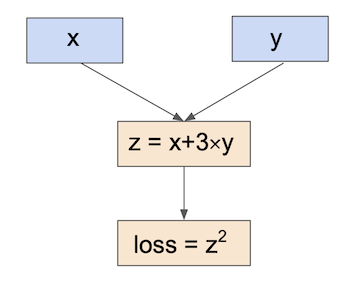

При создании новых тензоров, которые зависят от других тензоров, граф вычислений в PyTorch стротся автоматически. Те тензоры, которые являются обучаемыми параметрами, имеют поле requires_grad=True:

In [ ]:
x

In [ ]:
y

А те тензоры, которые являются функциями от обучаемых параметров, имеют поле grad_fn, которое содержит функцию вычисления производной этого тензора по его параметрам:

In [ ]:
z

In [ ]:
loss

Мы видим, что, действительно, у тензоров z и loss появилось поле grad_fn. Тезор z — это сумма тензоров x и y, поэтому его grad_fn — AddBackward0, т.е. его функция подсчета производной — функция производной суммы двух слагаемых. А loss — это тензор z, возведенный в степерь 2. Поэтому его grad_fn — это функция производной степенной функции. Обратите внимание, что grad_fn функции loss — это частная производная loss по z, а не сразу по x и y.

Формулы градиентов функций вида "сумма" и "степень" имеют стандартный вид. А сложные функции разбиваются на композицию таких стандартных функций. Т.е., как мы убедились еще в первом модуле, для сложных функций можно построить граф вычислений, в каждой вершине которого будет простая функция типа "сложение", "умножение", "синус" и т.п. Поэтому нет ничего волшебного в том, что в PyTorch реализовано автоматическое дифференцирование — это просто композиция стандартных функций.

Теперь мы можем вызвать метод .backward у тензора, который имеет grad_fn. При его вызове от этого тензора запустится механизм обратного распространения ошибки, который будет считать градиенты всех обучаемых параметров (тех тензоров, для которых requires_grad=True), входящих в граф вычислений.

In [ ]:
loss.backward()

В нашем случае результате будут посчитаны градиенты обучаемых параметров x и y:

In [ ]:
x.grad, y.grad

Давайте проверим, что градиенты были посчитаны правильно. Вручную посчитаем $\frac{d \ loss}{d x}$ и $\frac{d \ loss}{d x}$:

$$\frac{d \ loss}{d x} = 2(x+3y)$$
$$\frac{d \ loss}{d y} = 2(x+3y)*3$$

Тогда если подставить в эти формулы значения x и y:

$$\frac{d \ loss}{d x} (4, -2) = 2(4+3*(-2)) = -4$$
$$\frac{d \ loss}{d y} (4, -2) = 2(4+3*(-2))*3 = -12$$

Видим, что все посчиталось правильно.

Таким образом PyTorch производит автоматическое дифференцирование графов вычислений. Это очень удобно при реализации градиентного спуска. В качестве дополнительного домашнего задания к этому модулю мы предложим вам написать градиентный спуск функции одной переменной, используя torch.Tensor и его автоматическое дифференцирование.

А мы пока перейдем от простых функций к нейронным сетям:

## Autograd в нейросетях

Как мы поняли, нейросеть — это просто очень сложная функция. Поэтому идея autograd, описанная выше, будет применима и к подсчету градиентов обучаемых параметров нейросети. Но давайте подробнее разберем, как это делается.

Пусть мы построили такую нейросеть:

In [ ]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(2, 2)
        self.act1 = nn.Sigmoid()

        self.fc2 = nn.Linear(2, 1)
        self.act2 = nn.Sigmoid()


    def forward(self, x):

        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)
        return x

In [ ]:
net = Net()

При создании этой сети у слоев Linear задаются тензоры W и b, и они являются обучаемыми параметрами (т.е. имеют requires_grad=True). Всего у этой сети 4 обучаемых параметра — матрица весов и байесов (W и b) для каждого из двух линейных слоев.

Давайте в этом убедимся:

In [ ]:
# матрица W
net.fc1.weight

In [ ]:
# вектор b
net.fc1.bias

forward() определяет то, как входные данные в сеть будут проходить по слоям сети. То есть, forward определяет структуру графа вычислений. В нашем случае граф вычислений получится следующий:

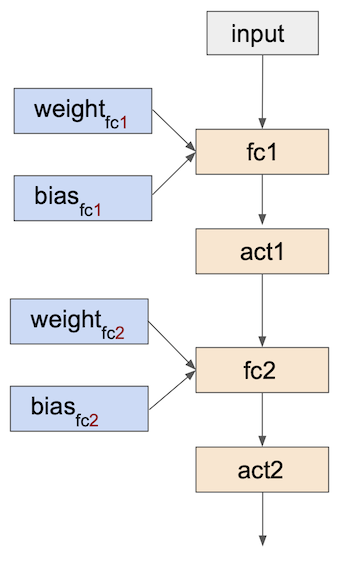

Напомним, как выглядит функция обучения сети:

In [ ]:
import tqdm
from tqdm.auto import tqdm

def train(model, X, y, criterion, optimizer, num_epoch):
    '''
    args:
        model - модель нейронной сети
        X и y - обучающая выборка
        criterion - функция потерь, взятая из модуля `torch.nn`
        optimizer - оптимизатор, взятый из модуля `torch.optim`
        num_epoch - количество эпох обучения.
    '''
    # цикл по количеству эпох обучения
    for t in tqdm(range(num_epoch)):
        # Вычислим предсказания нашей модели
        y_pred = model(X)

        # Посчитаем значение функции потерь  на полученном предсказании
        loss = criterion(y_pred, y)

        # Выполним подсчёт новых градиентов
        loss.backward()
        # Выполним шаг градиентного спуска
        optimizer.step()
        # Обнулим сохраненные у оптимизатора значения градиентов
        # перед следующим шагом обучения
        optimizer.zero_grad()

    return model

Во время обучения сети на каждой итерации после подачи батча данных на вход сети (т.е. после вызова функции forward) ответ сети подается в лосс-функцию. То есть, после каждого вызова forward полный граф вычислений будет выглядеть так:

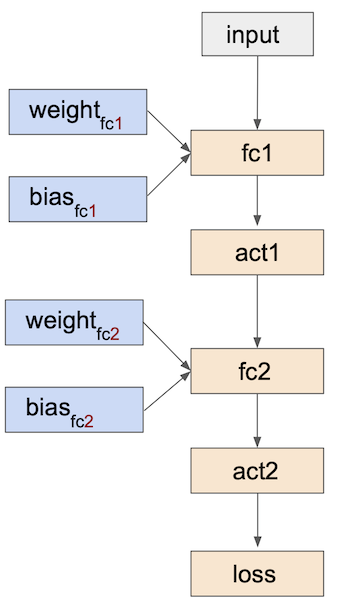

После этого мы выполняем loss.backward(), который запускает подсчет градиентов всех обучаемых параметров графа вычислений.

Давайте убедимся в этом:

In [ ]:
X = torch.randn((3, 2))
y = torch.FloatTensor([[0], [1], [0]])
criterion = torch.nn.BCELoss()

y_pred = net(X)
loss = criterion(y_pred, y)
loss.backward()

Посмотрим на поля grad обучаемых параметров:

In [ ]:
net.fc1.weight.grad

In [ ]:
net.fc1.bias.grad

Видим, что градиенты действительно были посчитаны.

Обратите внимание, что граф вычислений строится именно во время вызова функции forward(), а не во время создания сети. И при каждом вызове forward граф строится заново. Это важно, потому что в зависимости от итерации обучения прохождение входных данных по сети может быть разным. Возьмем тот же пример из предыдущего ноутбука:

In [ ]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc11 = nn.Linear(2, 2)
        self.act11 = nn.Sigmoid()

        self.fc12 = nn.Linear(2, 2)
        self.act12 = nn.Sigmoid()

        self.fc2 = nn.Linear(2, 1)
        self.act2 = nn.Sigmoid()


    def forward(self, x, mode='left'):

        if mode == 'left':
            x = self.fc11(x)
            x = self.act11(x)

        elif mode == 'right':
            x = self.fc12(x2)
            x = self.act12(x2)

        x = self.fc2(x)
        x = self.act2(x)
        return x

In [ ]:
net = Net()

In [ ]:
X = torch.randn((3, 2))
y = torch.FloatTensor([[0], [1], [0]])
criterion = torch.nn.BCELoss()

Мы можем по-разному вызвать функцию forward у нашей сети:

In [ ]:
y_pred = net(X, model='left')
loss = criterion(y_pred, y)
# или
y_pred = net(X, model='right')
loss = criterion(y_pred, y)

В двух этих случаях будут построены разные графы вычислений:

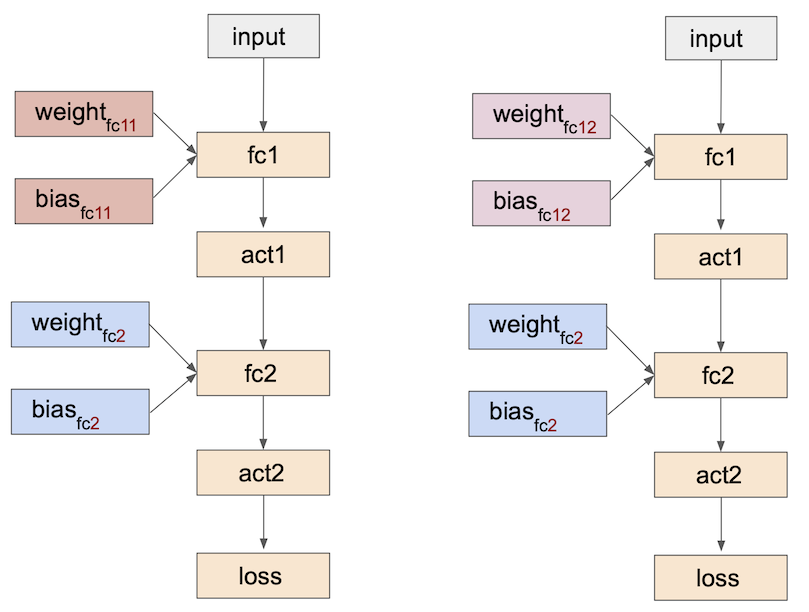

Вот так в PyTorch происходит вычисление градиентов всех параметров. И поэтому не нужно определять функцию backward у классов нейросетей.

Теперь еще становится понятно, почему оптимизатору не нужно передавать на вход градиенты параметров, а только сами параметры сети. Потому что информация о градиентах аккумулируется в самих тензорах-параметрах, и оптимизатор может их добыть, вызвав parameter.grad.

In [ ]:
# при создании
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3)
# при обучении
optimizer.step

## torch.no_grad()

Напоследок скажем вот что: выше мы поняли, что поля grad_fn тензоров, которые являются функциями от обучаемых параметров, заполняются во время построения графа вычислений, т.е. во время forward прохода. Сами численные значения производных вычисляются только после вызова .backward(), но вид производных генерируется сразу при построении графа вычислений.

In [ ]:
x = torch.tensor([4.], requires_grad = True)
y = torch.tensor([-2.], requires_grad = True)

z = x+3*y
loss = z**2

z.grad_fn

Теперь представьте, что мы тестируем нейронную сеть на тестовых данных. Тестирование состоит в том, что мы берем тестовые данные, подаем на вход сети, получаем ответы сети и сравниваем их с верными ответами с помощью какой-то метрики. Когда мы подаем тестовые данные на вход сети, мы делаем forward сети, при котором строится граф вычислений. А значит, генерируются функции вычисления производных `grad_fn` всех тензоров, входящих в этот граф.

Эта генерация занимает время и дополнительную память. Чтобы этого избежать, можно использовать [torch.no_grad()](https://pytorch.org/docs/stable/generated/torch.no_grad.html):

In [ ]:
x = torch.tensor([4.], requires_grad = True)
y = torch.tensor([-2.], requires_grad = True)

with torch.no_grad():
    z = x+3*y
    loss = z**2

z.grad_fn

Внутри `torch.no_grad` поле requires_grad всех тензоров становится False. Таким образом, grad_fn этих тензоров тоже вычисляться не будет.

Мы будем постоянно использовать эту конструкцию при тестировании нейросетей. Вы увидите ее использование уже в домашнем задании этого модуля.

## Полезные ссылки

- [Torch.autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) (PyTorch docs)
- [Torch.Tensor](https://pytorch.org/docs/stable/tensors.html#torch.Tensor) (PyTorch docs)